# Quick Start - From Python
Here we present a broad overview of using the PyBigDFT library to drive BigDFT calculations using Python. If you have installed from source, you should make sure you have setup the proper environment variables using the following command:

```
source install/bin/bigdftvars.sh
```

## System Manipulation
Here we define a system which is compsed of two fragments: H2 and Helium.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from BigDFT.Systems import System
from BigDFT.Fragments import Fragment
from BigDFT.Atoms import Atom
from BigDFT.Visualization import InlineVisualizer

In [3]:
# Create Three Atoms
at1 = Atom({"r": [0, 0, 0], "sym": "H", "units": "bohr"})
at2 = Atom({"r": [0, 0, 1.4], "sym": "H", "units": "bohr"})
at3 = Atom({"r": [10, 0, 0], "sym": "He", "units": "bohr"})

# Construct a System from Two Fragments (H2, He)
sys = System()
sys["H2:1"] = Fragment([at1, at2])
sys["He:2"] = Fragment([at3])

# Iterate Over The System
for fragid, frag in sys.items():
    for at in frag:
        print(fragid, at.sym, at.get_position())

H2:1 H [0.0, 0.0, 0.0]
H2:1 H [0.0, 0.0, 1.4]
He:2 He [10.0, 0.0, 0.0]


In [4]:
# NBVAL_IGNORE_OUTPUT
viz = InlineVisualizer(400, 300)
viz.display_system(sys)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Calculation
Calculate the created system using a grid spacing of $0.4$ and the PBE functional. A logfile is generated from which we can access the computed properties. This logfile has built in properties and can be accessed like a dictionary.

In [5]:
from BigDFT.Inputfiles import Inputfile
inp = Inputfile()
inp.set_hgrid(0.4)
inp.set_xc("PBE")
inp["perf"] = {"calculate_forces": False,
               "multipole_preserving": True}

In [6]:
from BigDFT.Calculators import SystemCalculator
calc = SystemCalculator(skip=True, verbose=False)

In [7]:
log = calc.run(sys=sys, input=inp, name="quick", run_dir="scratch")

In [8]:
print(log.energy)
print(log.log["Memory Consumption Report"]
             ["Memory occupation"])

-4.0538225545287325
{'Peak Value (MB)': 123.207, 'for the array': 'f_i', 'in the routine': 'vxcpostprocessing', 'Memory Peak of process': 'unknown'}


## Periodic Systems
We setup a BCC unit cell of iron and perform the calculation using a 2x2x2 k-point grid with a Monkhorst-Pack grid.

In [9]:
from BigDFT.UnitCells import UnitCell

In [10]:
pat = Atom({"Fe": [0, 0, 0], "units": "angstroem"})
psys = System({"CEL:0": Fragment([pat])})
psys.cell = UnitCell([2.867, 2.867, 2.867], units="angstroem")

In [11]:
# NBVAL_IGNORE_OUTPUT
viz = InlineVisualizer(400, 300)
viz.display_system(psys)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [12]:
inp = Inputfile()
inp.set_hgrid(0.3)
inp.set_xc("LDA")
inp["kpt"] = {"method": "mpgrid", "ngkpt": [2, 2, 2]}

In [13]:
log = calc.run(sys=psys, input=inp, name="psys", run_dir="scratch")

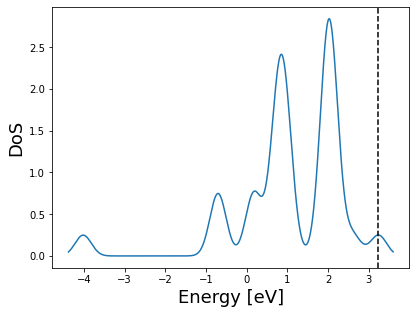

In [14]:
# NBVAL_IGNORE_OUTPUT
_ = log.get_dos().plot()

## File I/O
Read and write a PDB file.

In [15]:
from BigDFT.IO import read_pdb, write_pdb

In [16]:
with open("scratch/temp.pdb", "w") as ofile:
    write_pdb(sys, ofile)
with open("scratch/temp.pdb", "r") as ifile:
    sys = read_pdb(ifile)

## Linear Scaling
Activate the linear scaling mode of BigDFT and compute some per fragment quantities.

In [17]:
from BigDFT.PostProcessing import BigDFTool
from BigDFT.IO import read_mol2
from io import StringIO
from matplotlib import pyplot as plt
from BigDFT.Systems import plot_fragment_information

In [18]:
inp = Inputfile()
inp.set_hgrid(0.55)
inp.set_psp_nlcc()  # Soft pseudopotentials
inp.set_xc("PBE")
inp["import"] = "linear"

In [19]:
istr = """@<TRIPOS>MOLECULE
N3
 48 0 0 0 0
SMALL
GASTEIGER

@<TRIPOS>ATOM
      1  N        -15.9520   11.4820   75.1020 N.4     1  ALA         0.3855
      2  H        -16.8590   11.1760   75.4220 H       1  ALA        -0.0890
      3  H2       -15.9190   12.4910   75.1350 H       1  ALA        -0.0890
      4  H3       -15.3270   11.2070   75.8460 H       1  ALA        -0.0890
      5  CA       -15.6750   10.9380   73.6710 C.3     1  ALA        -0.0080
      6  HA       -15.5000    9.8640   73.7340 H       1  ALA         0.0175
      7  CB       -16.9370   11.1850   72.9780 C.3     1  ALA        -0.0702
      8  HB1      -16.8760   10.8330   71.9480 H       1  ALA         0.0218
      9  HB2      -17.7950   10.7240   73.4660 H       1  ALA         0.0218
     10  HB3      -17.0660   12.2620   72.8690 H       1  ALA         0.0218
     11  C        -14.3150   11.5090   73.1160 C.2     1  ALA         0.1989
     12  O        -13.5240   11.9470   73.9260 O.2     1  ALA        -0.2776
     13  N        -14.0770   11.2840   71.7960 N.am    2  VAL        -0.3051
     14  H        -14.7740   10.8610   71.1990 H       2  VAL         0.1494
     15  CA       -12.9310   11.8890   71.0690 C.3     2  VAL         0.1016
     16  HA       -12.1370   12.1190   71.7800 H       2  VAL         0.0597
     17  CB       -12.2680   10.8300   70.1710 C.3     2  VAL        -0.0197
     18  HB       -13.0570   10.2210   69.7300 H       2  VAL         0.0318
     19  CG1      -11.2730   11.3540   69.0870 C.3     2  VAL        -0.0605
     20 HG11      -10.7560   10.5590   68.5490 H       2  VAL         0.0233
     21 HG12      -11.7530   11.9770   68.3320 H       2  VAL         0.0233
     22 HG13      -10.5100   11.8940   69.6470 H       2  VAL         0.0233
     23  CG2      -11.4480    9.8090   70.9840 C.3     2  VAL        -0.0605
     24 HG21      -11.9590    9.4330   71.8700 H       2  VAL         0.0233
     25 HG22      -11.3140    8.9080   70.3860 H       2  VAL         0.0233
     26 HG23      -10.4970   10.2560   71.2750 H       2  VAL         0.0233
     27  C        -13.2980   13.1490   70.4060 C.2     2  VAL         0.2342
     28  O        -14.1940   13.1280   69.5820 O.2     2  VAL        -0.2738
     29  N        -12.5920   14.2640   70.6930 N.am    3  LEU        -0.3007
     30  H        -11.8060   14.2210   71.3260 H       3  LEU         0.1496
     31  CA       -12.8570   15.7250   70.2250 C.3     3  LEU         0.1249
     32  HA       -13.7770   15.8070   69.6470 H       3  LEU         0.0616
     33  CB       -12.9890   16.4610   71.5050 C.3     3  LEU        -0.0216
     34  HB2      -12.3120   16.1130   72.2850 H       3  LEU         0.0291
     35  HB3      -12.7420   17.5000   71.2880 H       3  LEU         0.0291
     36  CG       -14.4560   16.4840   72.0620 C.3     3  LEU        -0.0445
     37  HG       -15.0910   16.5870   71.1830 H       3  LEU         0.0296
     38  CD1      -14.9030   15.1850   72.7940 C.3     3  LEU        -0.0626
     39 HD11      -15.9610   15.3610   72.9910 H       3  LEU         0.0232
     40 HD12      -14.8720   14.2770   72.1920 H       3  LEU         0.0232
     41 HD13      -14.2220   15.0500   73.6340 H       3  LEU         0.0232
     42  CD2      -14.5970   17.6630   72.9710 C.3     3  LEU        -0.0626
     43 HD21      -15.6450   17.5910   73.2620 H       3  LEU         0.0232
     44 HD22      -13.9320   17.5610   73.8280 H       3  LEU         0.0232
     45 HD23      -14.3580   18.5620   72.4040 H       3  LEU         0.0232
     46  C        -11.7070   16.2810   69.3360 C.2     3  LEU         0.3758
     47  O        -10.5210   15.8410   69.5920 O.co2   3  LEU        -0.2443
     48  OXT      -11.9460   17.0960   68.3940 O.co2   3  LEU        -0.2443
"""
Lsys = read_mol2(StringIO(istr))

In [20]:
log = calc.run(sys=Lsys, input=inp, name="Lsys", run_dir="scratch")

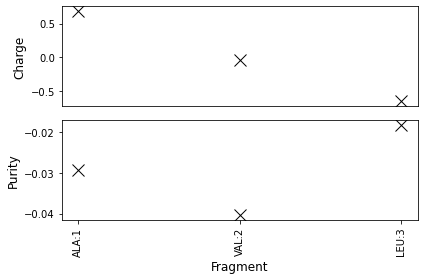

In [21]:
# NBVAL_IGNORE_OUTPUT
fig, axs = plt.subplots(2, 1)
btool = BigDFTool()
plot_fragment_information(axs[0], btool.fragment_population(Lsys, log))
axs[0].set_ylabel("Charge", fontsize=12)
axs[0].set_xticks([])
axs[0].set_xlabel("")
plot_fragment_information(axs[1], btool.run_compute_purity(Lsys, log))
axs[1].set_ylabel("Purity", fontsize=12)
fig.tight_layout()